In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 160
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})

In [2]:
import numpy as np
from skimage.io import imread
from skimage.util import montage as montage2d
import pandas as pd
from pathlib import Path
data_dir = Path('./drawings/')

## Organize Datasets
Here we organize the datasets by directory so we can see the breakdown a bit better

In [3]:
draw_df = pd.DataFrame({'path': list(data_dir.glob('*/*/*/*.png'))})
draw_df['img_id'] = draw_df['path'].map(lambda x: x.stem)
draw_df['disease'] = draw_df['path'].map(lambda x: x.parent.stem)
draw_df['validation'] = draw_df['path'].map(lambda x: x.parent.parent.stem)
draw_df['activity'] = draw_df['path'].map(lambda x: x.parent.parent.parent.stem)
print(draw_df.shape, 'images loaded')
draw_df.sample(3)

(204, 5) images loaded


path   img_id    disease  \
69   drawings\spiral\training\parkinson\V02PE03.png  V02PE03  parkinson   
35      drawings\spiral\training\healthy\V03HE3.png   V03HE3    healthy   
142      drawings\wave\training\healthy\V06HO02.png  V06HO02    healthy   

    validation activity  
69    training   spiral  
35    training   spiral  
142   training     wave

# Show Images

In [4]:
def fixed_imread(in_path, resize=True):
    """read images, invert and scale them"""
    c_img = 1.0-imread(in_path, as_gray=True)
    max_dim = np.max(c_img.shape)
    if not resize:
        return c_img
    if c_img.shape==(256, 256):
        return c_img
    if max_dim>256:
        big_dim = 512
    else:
        big_dim = 256
        
    out_img = np.zeros((big_dim, big_dim), dtype='float32')
    c_offset = (big_dim-c_img.shape[0])//2
    d_offset = c_img.shape[0]+c_offset
    
    e_offset = (big_dim-c_img.shape[1])//2
    f_offset = c_img.shape[1]+e_offset
    out_img[c_offset:d_offset, e_offset:f_offset] = c_img[:(d_offset-c_offset), :(f_offset-e_offset)]
    return out_img

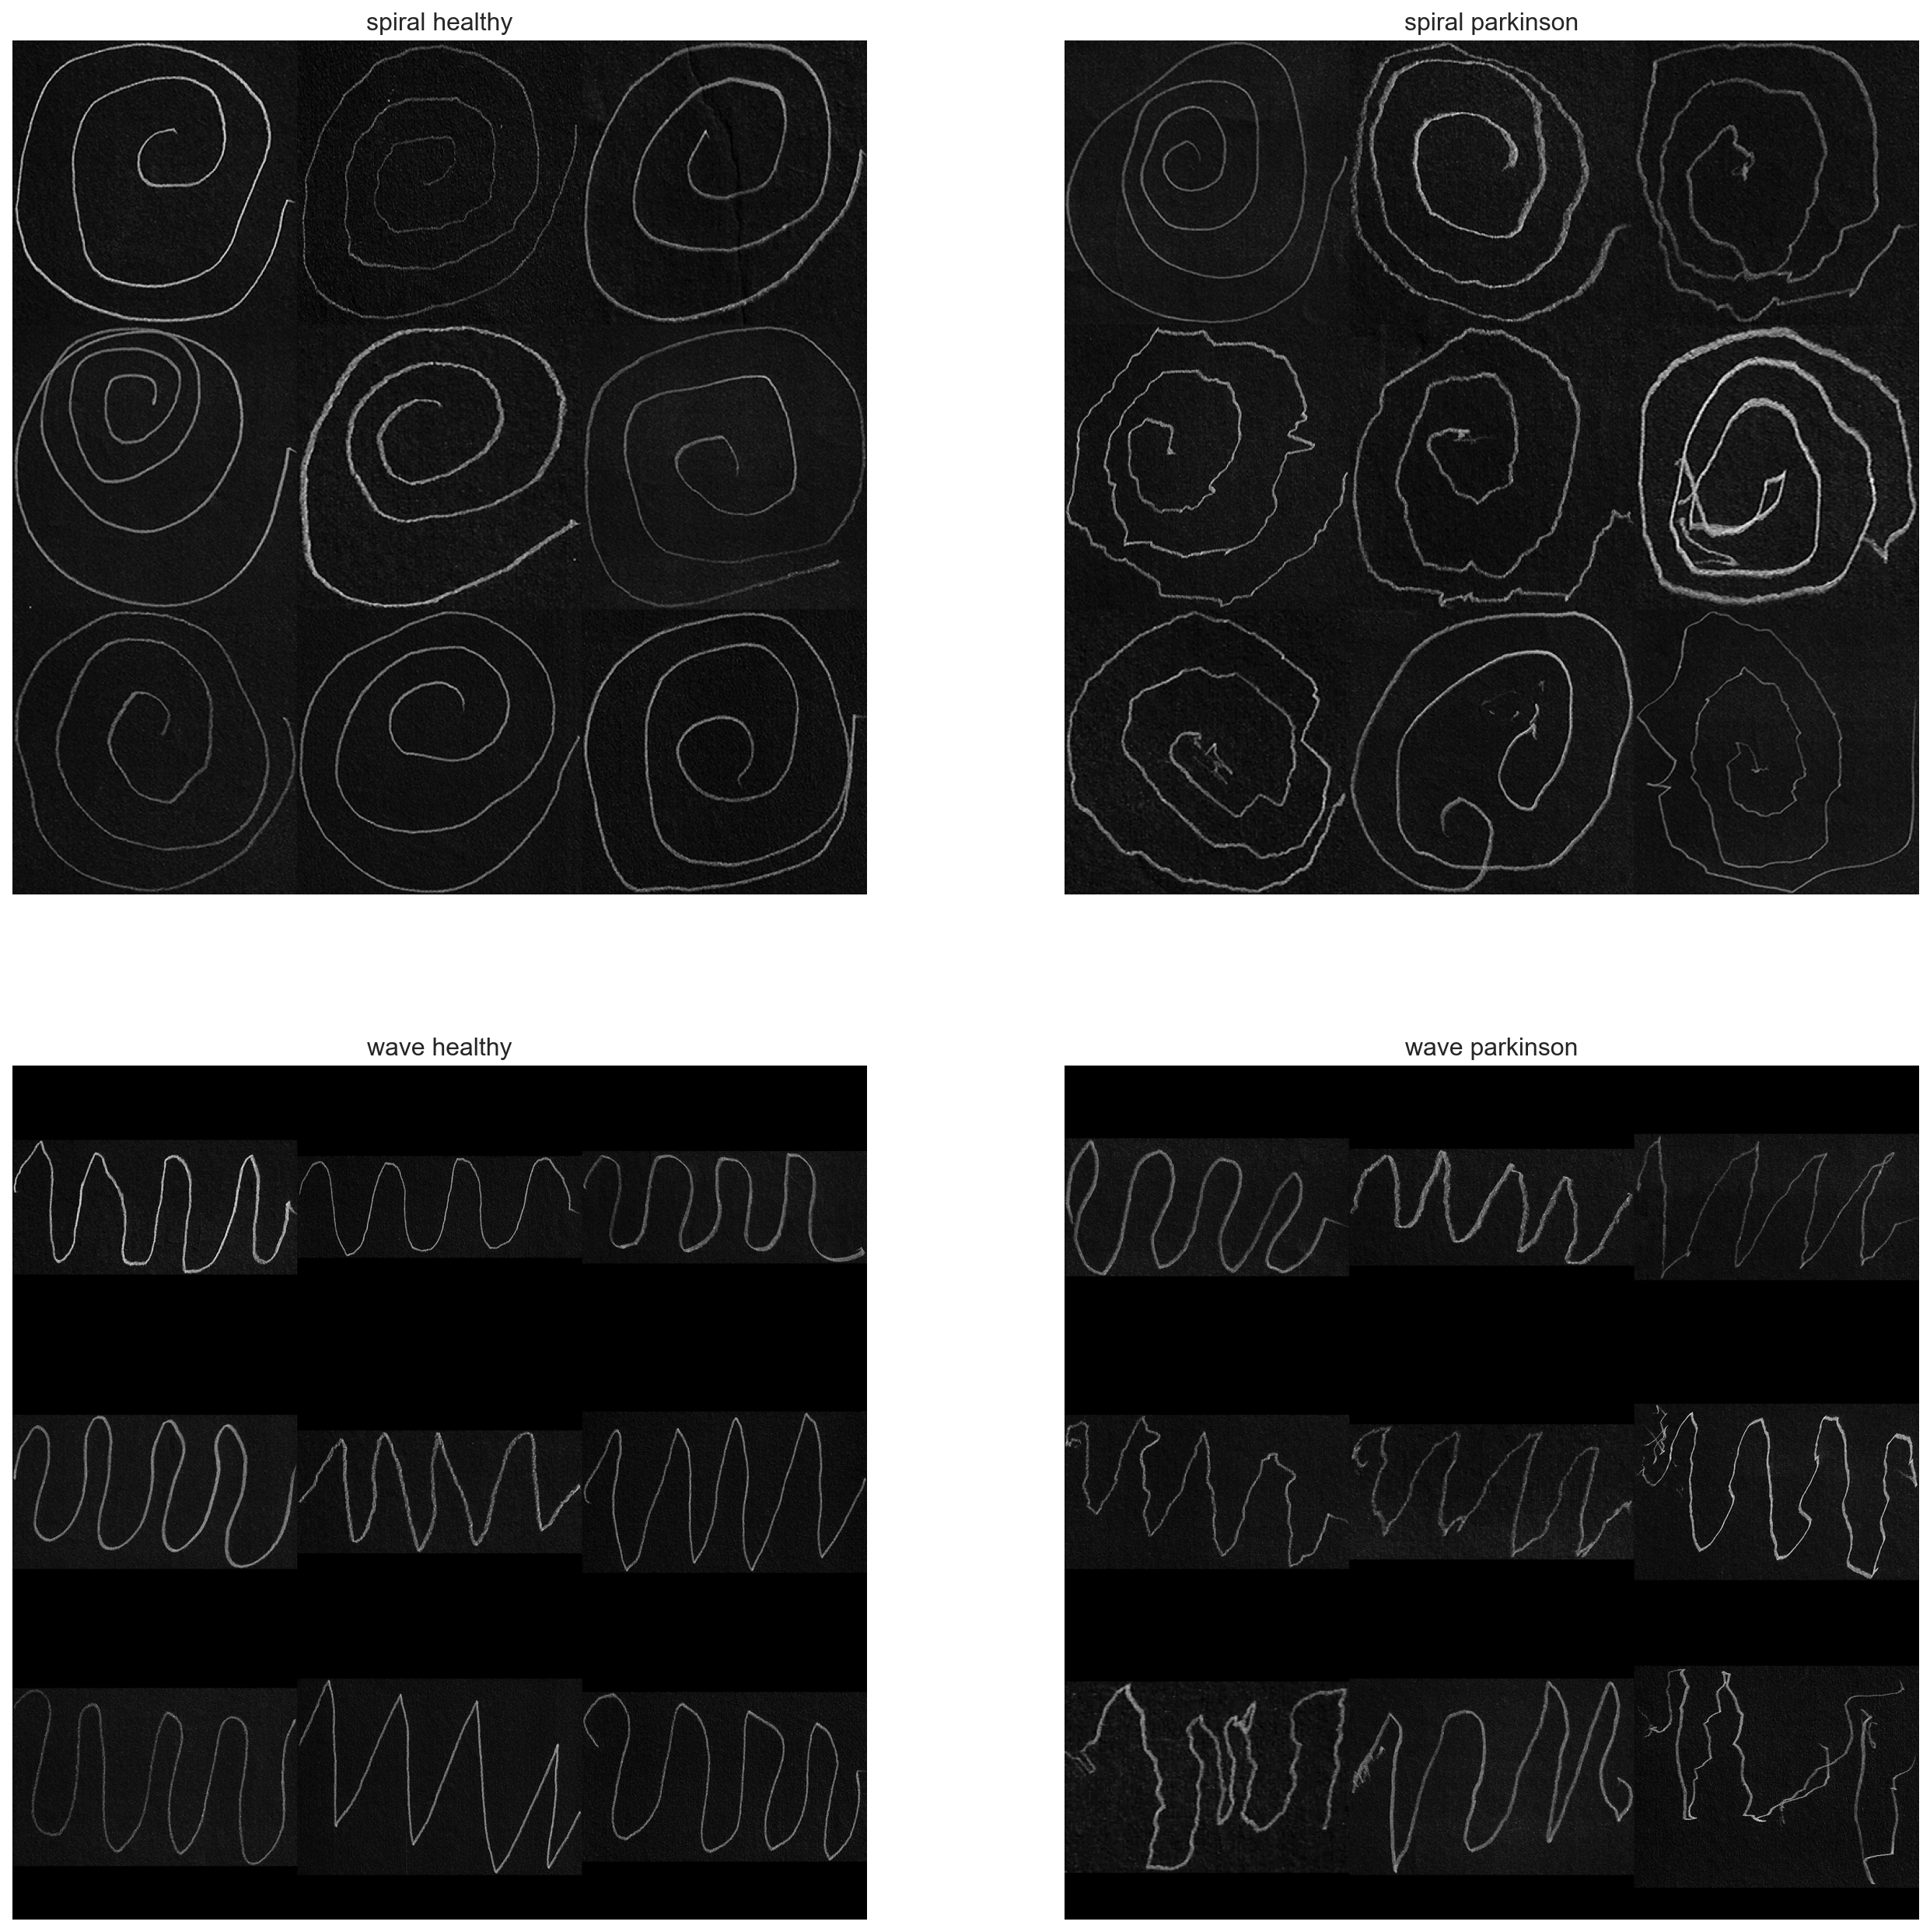

In [5]:
fig, m_axs = plt.subplots(2, 2, figsize=(20, 20))
for c_ax, (c_lab, c_rows) in zip(m_axs.flatten(), draw_df.groupby(['activity', 'disease'])):
    prev_img = montage2d(np.stack([fixed_imread(x) for x in c_rows['path'].iloc[0:9]], 0))
    c_ax.imshow(prev_img, cmap='gray')
    c_ax.set_title(' '.join(c_lab))
    c_ax.axis('off')

# Filter and Segment
We can filter and segment the images in order to extract the drawings more clearly as just drawing pixels and noise

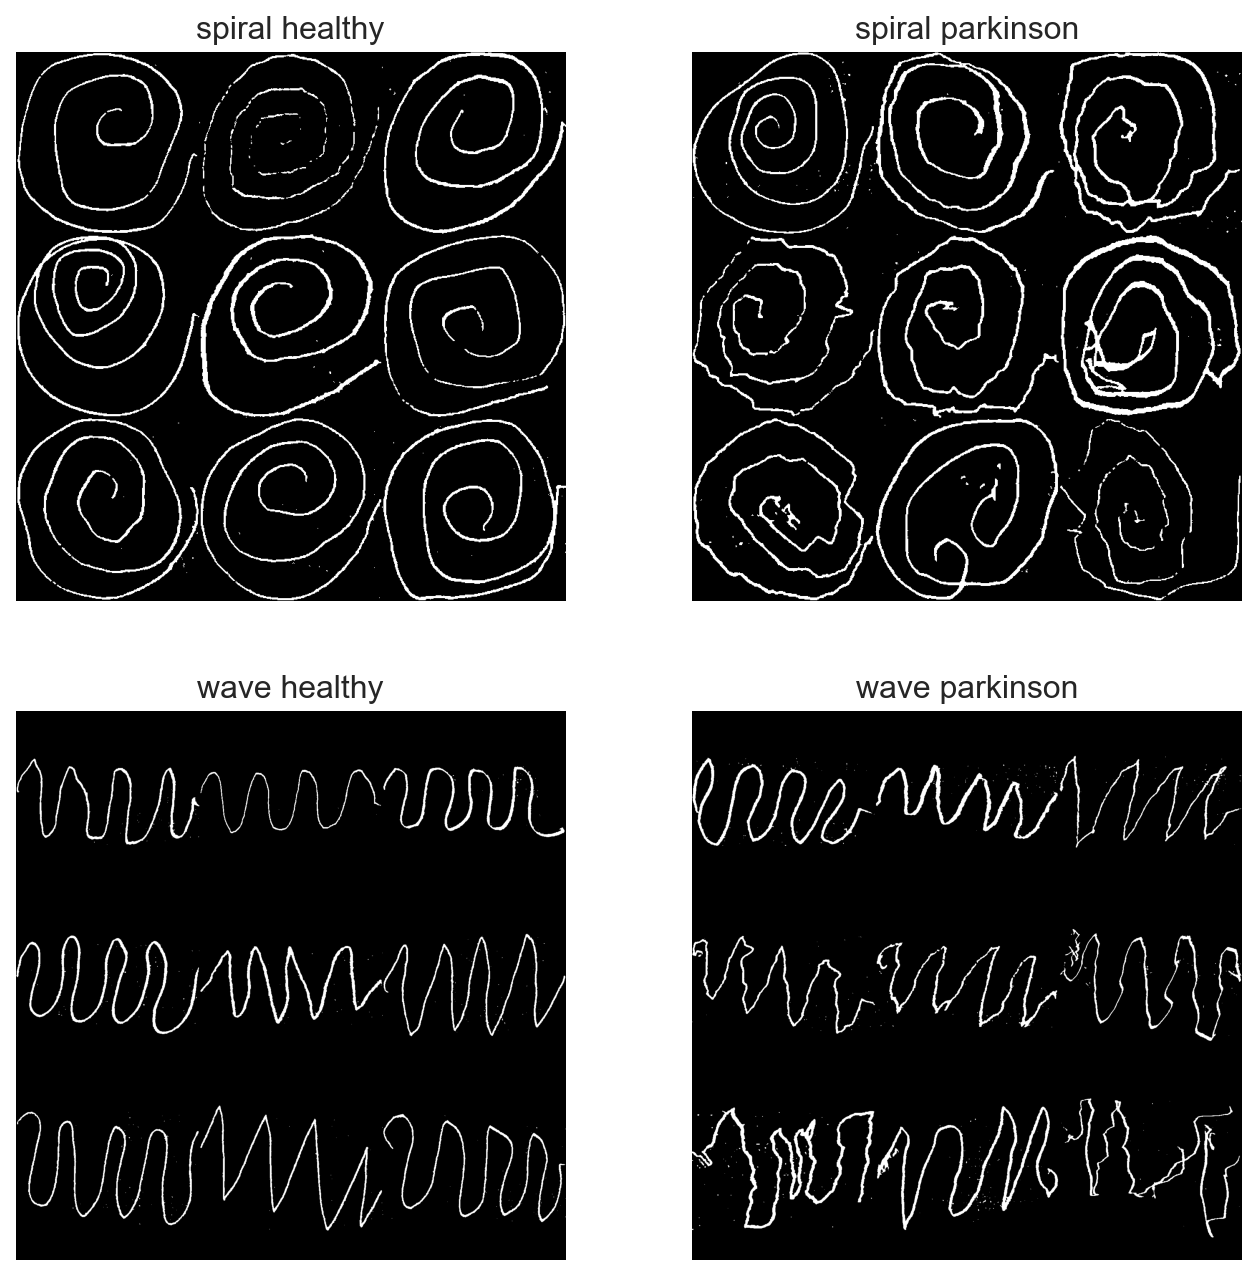

In [6]:
from skimage.filters import threshold_yen as thresh_func
from skimage.filters import median
from skimage.morphology import disk, opening, diamond

def read_and_thresh(in_path, resize=True):
    c_img = fixed_imread(in_path, resize=resize)
    c_img = (255*c_img).clip(0, 255).astype('uint8')
    c_img = median(c_img, disk(2))
    c_thresh = thresh_func(c_img)
    return c_img>c_thresh
fig, m_axs = plt.subplots(2, 2, figsize=(10, 10))
for c_ax, (c_lab, c_rows) in zip(m_axs.flatten(), draw_df.groupby(['activity', 'disease'])):
    prev_img = montage2d(np.stack([read_and_thresh(x) for x in c_rows['path'].iloc[0:9]], 0))
    c_ax.imshow(prev_img, cmap='gray')
    c_ax.set_title(' '.join(c_lab))
    c_ax.axis('off')

In [7]:
%%time
# run all images
draw_df['thresh_img'] = draw_df['path'].map(lambda x: read_and_thresh(x, resize=False))

Wall time: 7.84 s


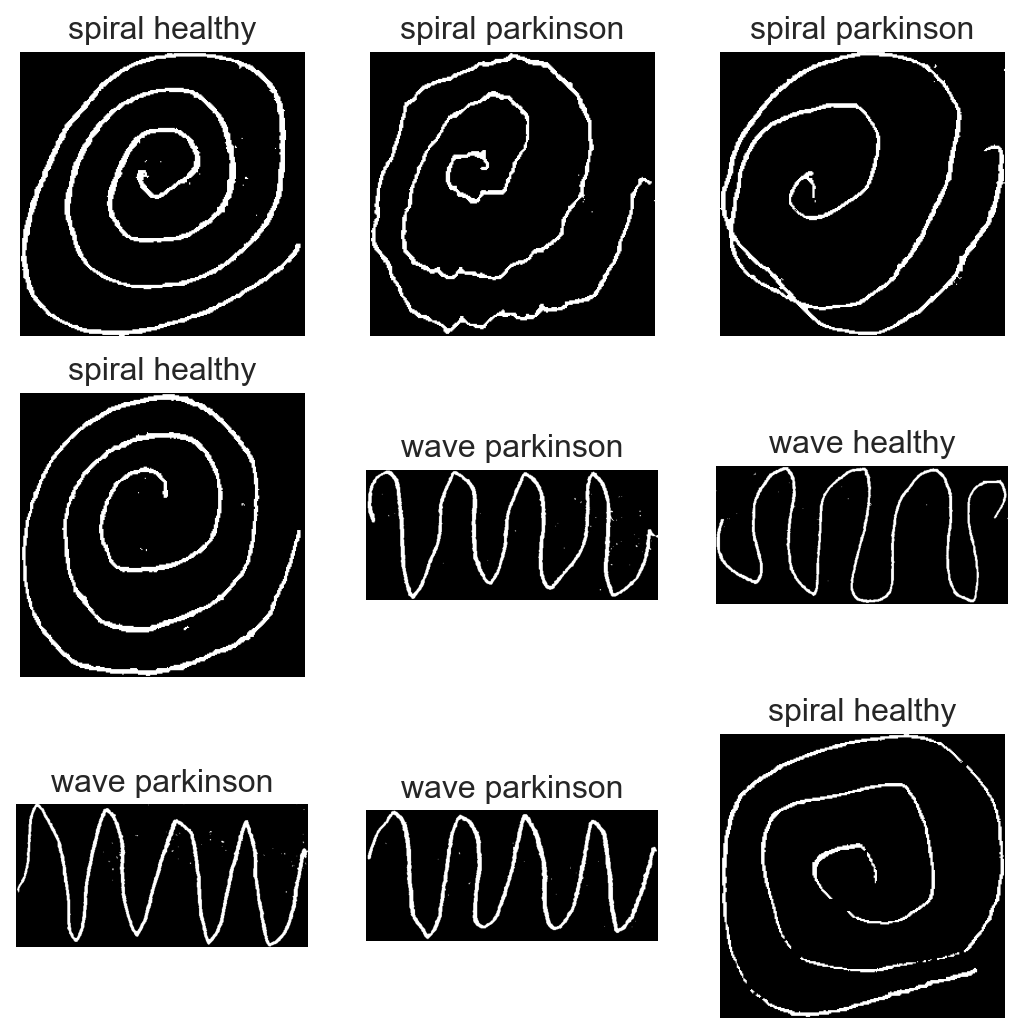

In [8]:
fig, m_axs = plt.subplots(3, 3)
for c_ax, (c_lab, c_row) in zip(m_axs.flatten(), draw_df.sample(9).iterrows()):
    c_ax.imshow(c_row['thresh_img'], cmap='gray')
    c_ax.set_title('{activity} {disease}'.format(**c_row))
    c_ax.axis('off')

## Keep only large enough components
Only keep objects larger than 10% of the total activated pixels

In [9]:
from skimage.morphology import label
from skimage.morphology import closing
def label_sort(in_img, cutoff=0.1):
    total_cnt = np.sum(in_img>0)
    lab_img = label(in_img)
    new_image = np.zeros_like(lab_img)
    remap_index = []
    for k in np.unique(lab_img[lab_img>0]):
        cnt = np.sum(lab_img==k)
        if cnt>total_cnt*cutoff:
            remap_index+=[(k, cnt)]
    sorted_index = sorted(remap_index, key=lambda x: -x[1])
    for new_idx, (old_idx, idx_count) in enumerate(sorted_index, 1):
        new_image[lab_img==old_idx] = new_idx
    return new_image

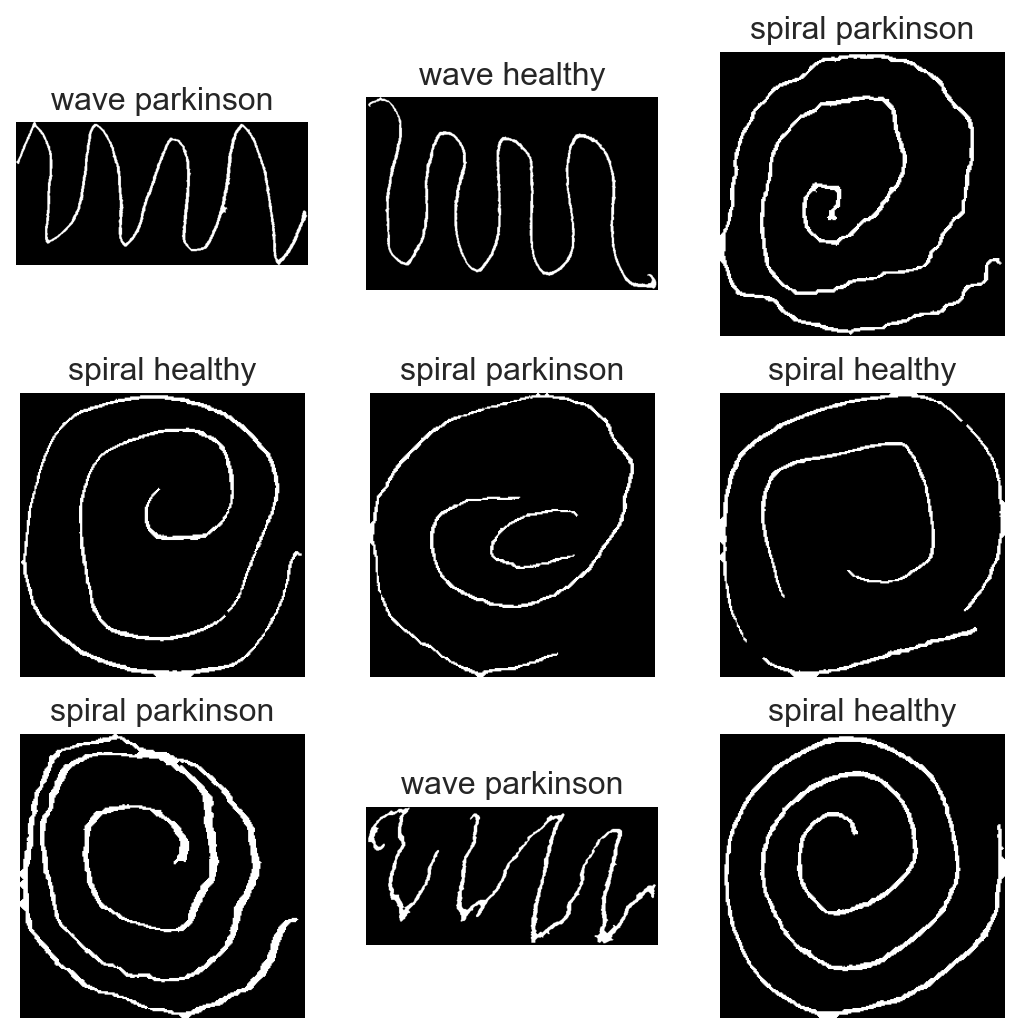

In [10]:
fig, m_axs = plt.subplots(3, 3)
for c_ax, (c_lab, c_row) in zip(m_axs.flatten(), draw_df.sample(9).iterrows()):
    clean_img = closing(label_sort(c_row['thresh_img'])>0, disk(2))
    c_ax.imshow(clean_img, cmap='gray')
    c_ax.set_title('{activity} {disease}'.format(**c_row))
    c_ax.axis('off')

In [11]:
%%time
draw_df['clean_img'] = draw_df['thresh_img'].map(lambda x: closing(label_sort(x)>0, disk(2)))

Wall time: 3.22 s


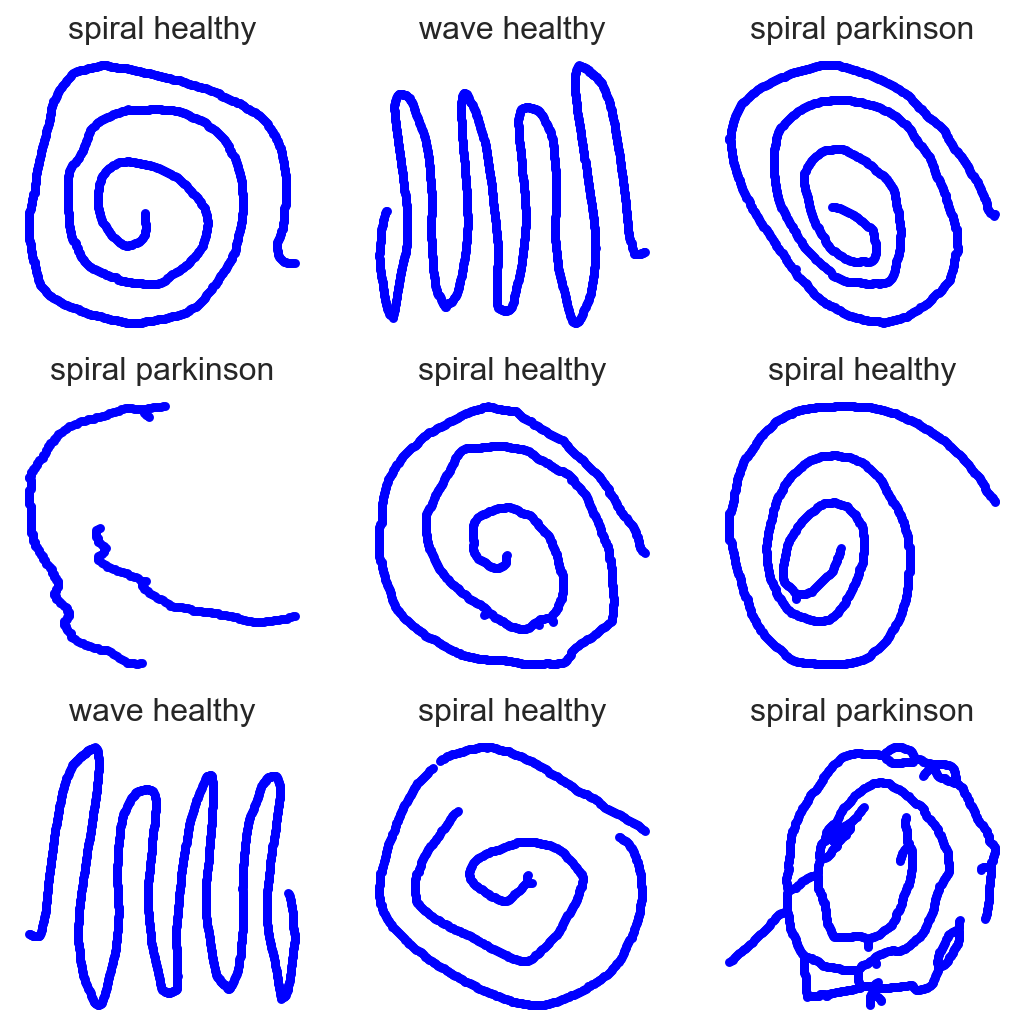

In [12]:
from skimage.morphology import skeletonize

fig, m_axs = plt.subplots(3, 3)
for c_ax, (c_lab, c_row) in zip(m_axs.flatten(), draw_df.sample(9).iterrows()):
    skel_img = skeletonize(c_row['clean_img'])
    skel_y, skel_x = np.where(skel_img)
    skel_x = skel_x*1.0/skel_img.shape[1]
    skel_y = skel_y*1.0/skel_img.shape[0]
    
    c_ax.plot(skel_x, skel_y, 'b.')
    c_ax.set_title('{activity} {disease}'.format(**c_row))
    c_ax.axis('off')

### Convert to table
We convert all of the detected skeleton points into a table and combine all of the results together

In [13]:
all_row_list = []
for _, c_row in draw_df.iterrows():
    skel_img = skeletonize(c_row['clean_img'])
    skel_y, skel_x = np.where(skel_img)
    skel_x = skel_x*1.0/skel_img.shape[1]
    skel_y = skel_y*1.0/skel_img.shape[0]
    for x, y in zip(skel_x, skel_y):
        d_row = dict(**{k: v for k,v in c_row.items() if len(np.shape(v))<1})
        d_row['x'] = x
        d_row['y'] = y
        all_row_list += [d_row]

In [14]:
all_row_df = pd.DataFrame(all_row_list)
all_row_df.sample(3)

path   img_id    disease  \
322190   drawings\wave\training\parkinson\V15PO02.png  V15PO02  parkinson   
30013   drawings\spiral\testing\parkinson\V06PE01.png  V06PE01  parkinson   
235640     drawings\wave\training\healthy\V12HO01.png  V12HO01    healthy   

       validation activity         x         y  
322190   training     wave  0.888672  0.721477  
30013     testing   spiral  0.457031  0.207031  
235640   training     wave  0.730469  0.620072

## Show all of the drawings on the same axis
By plotting the skeleton pixels as points and rescaling we can overlay all of the images on top of each other for better visualization. The healthy patients are significantly more consistent than the Parkinson's.

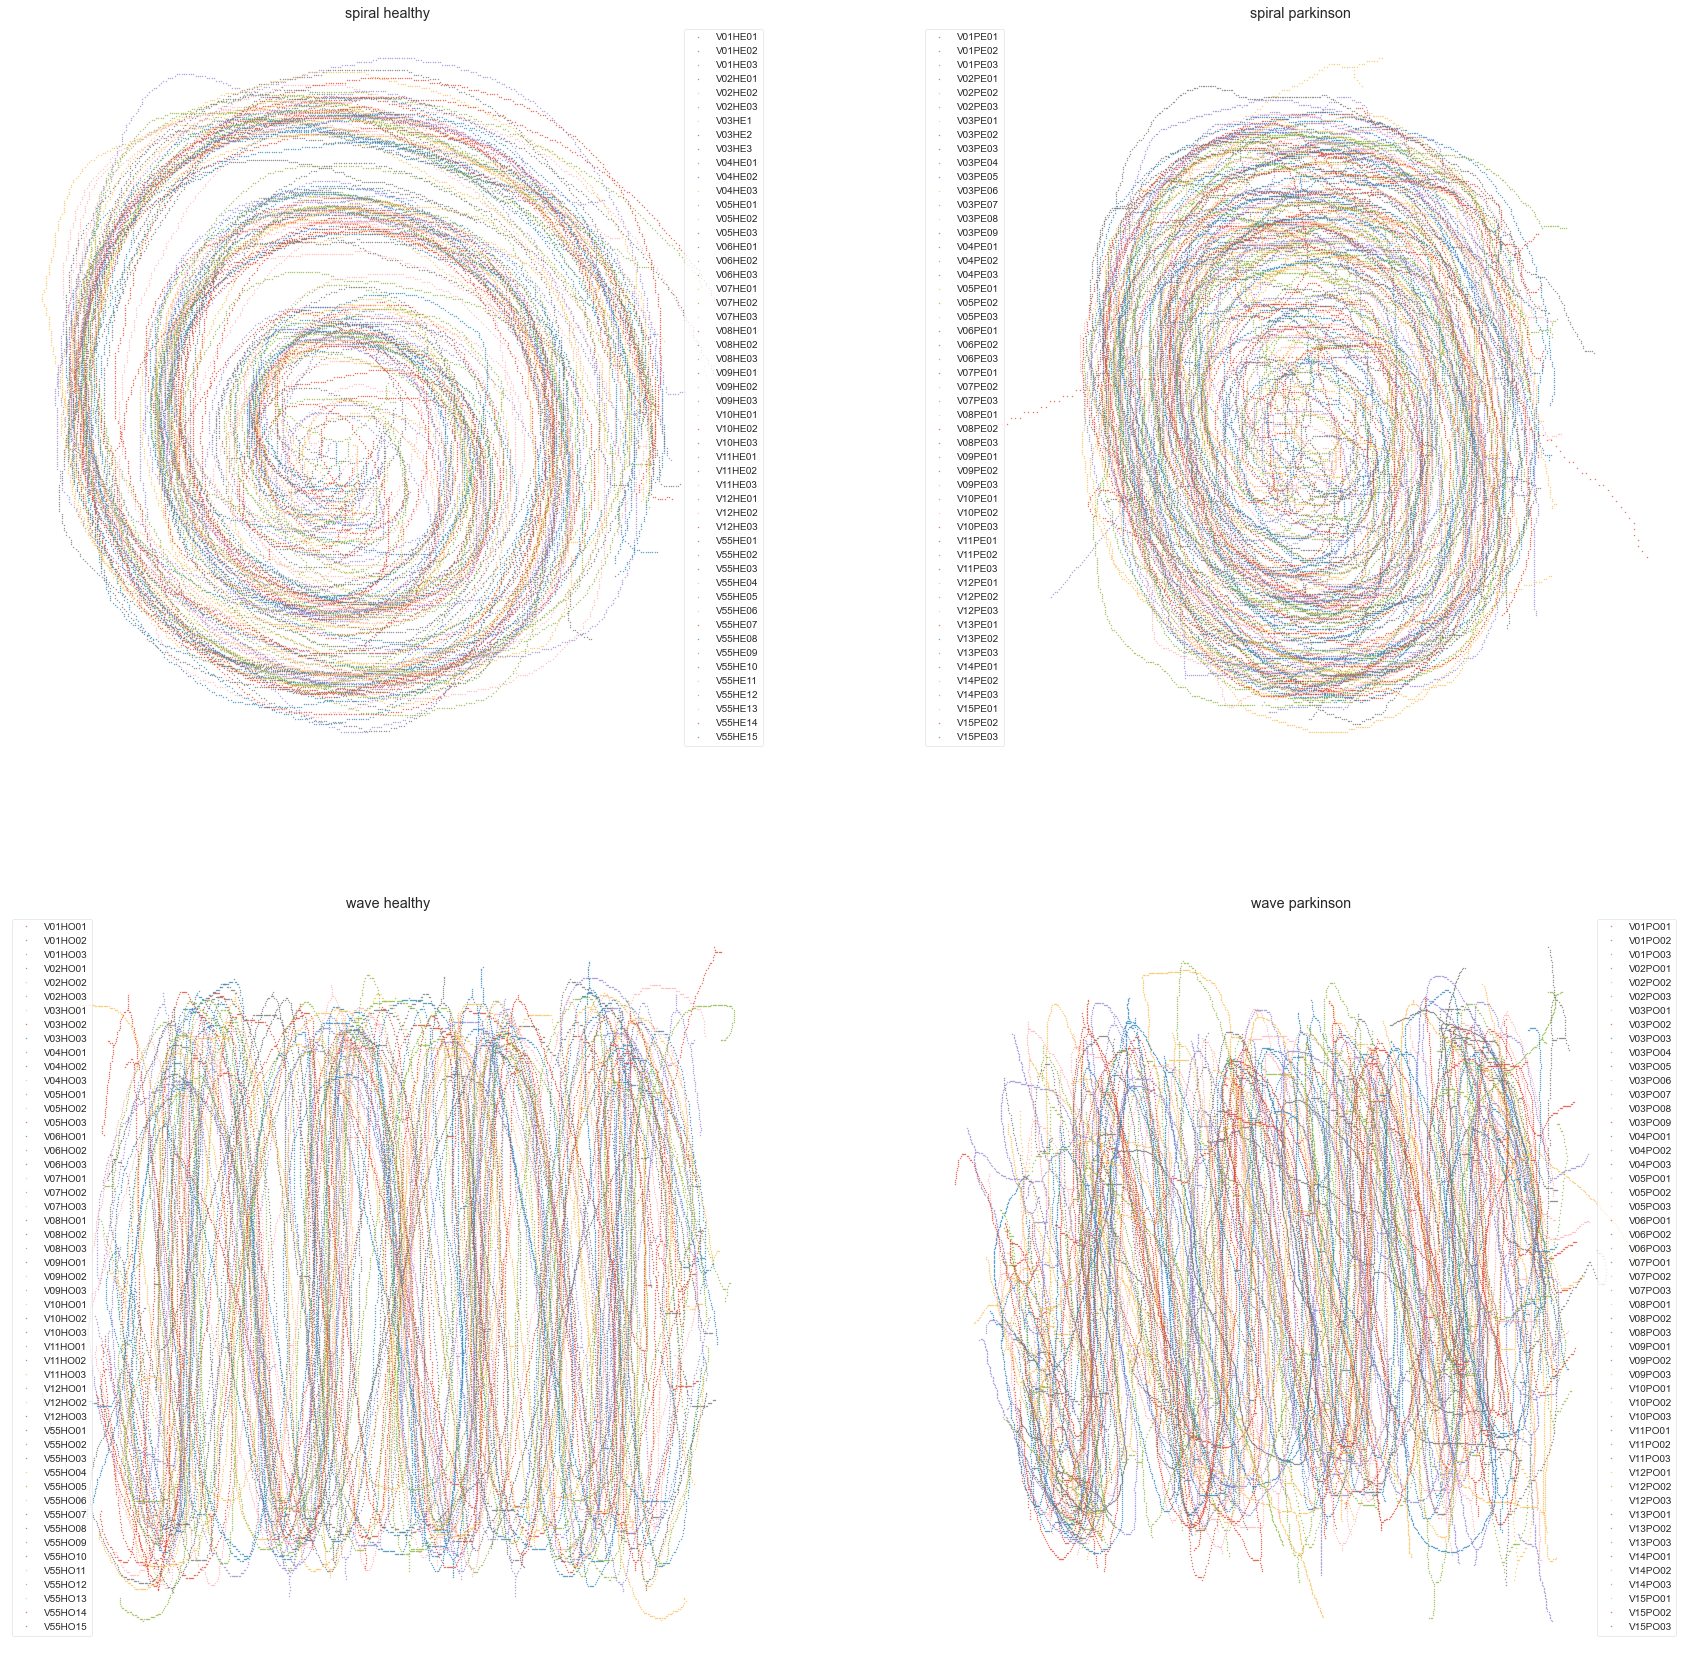

In [15]:
fig, m_axs = plt.subplots(2, 2, figsize=(30, 30), dpi=72)
for c_ax, (c_lab, c_rows) in zip(m_axs.flatten(), all_row_df.groupby(['activity', 'disease'])):
    for c_id, d_rows in c_rows.groupby('img_id'):
        mean_std = np.mean([d_rows['x'].std(), d_rows['y'].std()])
        c_ax.plot((d_rows['x']-d_rows['x'].mean())/mean_std, 
                  (d_rows['y']-d_rows['y'].mean())/mean_std, '.', label=c_id, ms=0.75)
    c_ax.legend()
    c_ax.set_title(' '.join(c_lab))
    c_ax.axis('off')

# Next Steps
1. Try and order the curves and get realistic (if possibly inaccurate) trajectories for the pen movement
2. Quantify the pressure by looking at the thickness of the skeleton at specific points.
3. Start to quantify the 'jigglyness' of the motion (fourier analysis of the time series?, differential motion?)
